# Zayn+Nevin Skin Lesion Classifier

In [1]:
import torch
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets, transforms
import numpy as np
import datetime, os
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DataLoader = torch.utils.data.DataLoader

SEED = 1
torch.manual_seed(SEED)

### Hyperparameters

In [2]:
num_epochs = 2
batch_size = 32 # Pacheco et al. used batch_size=30
learning_rate = 0.01

In [3]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

### Set the paths

In [4]:
# from google.colab import drive
# drive.mount('/content/drive/')

# data_path = '/content/drive/My Drive/CS230_Project/PAD-UFES-20/'
data_path = '/Users/nevingeorge/Desktop/CS230/Project/PAD-UFES-20/'

# log_dir_path = "/content/drive/My Drive/CS230_Project/runs"
log_dir_path = '/Users/nevingeorge/Desktop/CS230/Project/skin-lesion-classifier/runs'

Loading the `metadata`, initializing `label_dict` : {"patient id" --> "diagnostic"}

In [5]:
metadata_path = data_path + 'metadata.csv'
metadata = pd.read_csv(metadata_path)
label_dict = metadata.set_index("img_id")["diagnostic"].to_dict()

In [6]:
class PAD_UFES_Dataset(Dataset):
    def __init__(self, img_dir, label_dict, transform=None):
        self.img_dir = img_dir
        self.label_dict = label_dict
        self.transform = transform
        # This provides standard indexing, which I believe Pytorch requires for __getitem__
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith('.png')] # Just in case a stray file shows up in there..

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Retrieves filename and patient_id
        img_name = self.image_files[idx]
        # Loads the image
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        # Applies our basic transformations, for now
        if self.transform:
            image = self.transform(image)

        # Gets the label, slaps us with a -1 if I messed up earlier.
        label = self.label_dict.get(img_name, -1)
        label = classes.index(label) # convert label (string) into the corresponding index in classes

        return image, label, img_name


In [7]:
img_dir = data_path + 'imgs/'
dataset = PAD_UFES_Dataset(img_dir=img_dir, label_dict=label_dict, transform=transform)
dataset_size = len(dataset)
print("Number of images:", dataset_size)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print("Dataset and DataLoader initialized.")

Number of images: 2298
Dataset and DataLoader initialized.


In [8]:
classes = ["ACK", "BCC", "MEL", "NEV", "SCC", "SEK"]
print("Classes:", classes)
output_size = len(classes)

Classes: ['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK']


In [9]:
# Directly access a few samples to test `__getitem__`
for i in range(10):
    image, label, img_name = dataset[i]
    print(f"ImageName: {img_name}, label: {classes[label]}")

ImageName: PAT_887_1688_436.png, label: BCC
ImageName: PAT_431_850_472.png, label: BCC
ImageName: PAT_554_1051_301.png, label: BCC
ImageName: PAT_1468_1622_219.png, label: ACK
ImageName: PAT_759_1433_973.png, label: NEV
ImageName: PAT_1483_1678_538.png, label: ACK
ImageName: PAT_604_1150_336.png, label: BCC
ImageName: PAT_1031_148_66.png, label: ACK
ImageName: PAT_365_751_709.png, label: SCC
ImageName: PAT_355_732_102.png, label: BCC


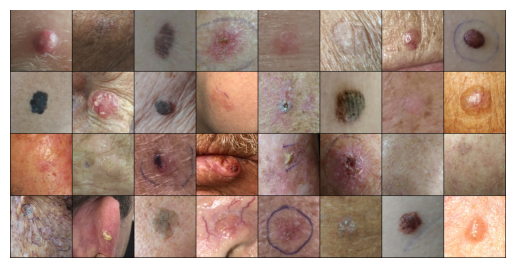

Image shape (batch size, channels, height, width): torch.Size([32, 3, 224, 224])
Labels: ['NEV', 'ACK', 'NEV', 'BCC', 'BCC', 'SEK', 'BCC', 'NEV', 'MEL', 'BCC', 'SEK', 'ACK', 'BCC', 'NEV', 'ACK', 'BCC', 'ACK', 'ACK', 'BCC', 'SCC', 'ACK', 'ACK', 'ACK', 'ACK', 'ACK', 'SCC', 'SEK', 'BCC', 'ACK', 'ACK', 'NEV', 'BCC']


In [10]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get a batch of images + labels, thanks to our yummy DataSet
images, labels, img_names = next(iter(train_dataloader))
imshow(torchvision.utils.make_grid(images))

print("Image shape (batch size, channels, height, width):", images.shape)
_, channels, image_height, image_width = images.shape

label_names = [classes[label] for label in labels]
print("Labels:", label_names)

In [11]:
class SimpleConvNet(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(24*24*32, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, output_size)

    def forward(self, x):
        # x.shape = 224x224x3
        x = self.pool(F.relu(self.conv1(x))) # x.shape = 110x110x8
        x = self.pool(F.relu(self.conv2(x))) # x.shape = 53x53x16
        x = self.pool(F.relu(self.conv3(x))) # x.shape = 24x24x32
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

simpleConvNet = SimpleConvNet(output_size).to(DEVICE)

In [12]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(simpleConvNet.parameters(), lr=learning_rate)

In [13]:
# Saving models

"""
Ideally, you should be trying to save your model parameters at
every X number of iterations of training so that when you do
early stopping, you can revisit one of these parameter sets
and use those weights. This is also good practice in case of any errors
https://pytorch.org/tutorials/beginner/saving_loading_models.html
"""

def save_model_to_location(model, path):
    torch.save(model.state_dict(), path)
    return True

# Note that when loading, your model architecture must match identically
# to the weights set you are loading from and you must pass that model in here
def load_model_from_location(model, path):
    model.load_state_dict(torch.load(path, weights_only=True))
    return model

In [14]:
# Loggers -> These will log to the tensorboard
simpleConvNet_writer = SummaryWriter(log_dir = log_dir_path + '/simpleConvNet')

simpleConvNet.train()

for epoch in range(num_epochs):

    for i, data in enumerate(train_dataloader, 0):
        images, labels, _ = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()

        outputs = simpleConvNet(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        if i == 0 or i == int(dataset_size / (2 * batch_size)):
            print('Epoch: [{}/{}], Iterations: {}, Loss: {}'.format(epoch+1,num_epochs,i,loss.item()))
            simpleConvNet_writer.add_scalar('Loss/train', loss.item(), i + epoch * len(train_dataloader))
            # can add in validation accuracy here

simpleConvNet_writer.close()
print('Finished Training')

Epoch: [1/2], Iterations: 0, Loss: 1.857428789138794



KeyboardInterrupt



In [ ]:
def calc_accuracy(loader, model):
    model.eval()

    total, correct = 0, 0

    with torch.no_grad():
        for data in loader:
            images, labels, _ = data
            outputs = model(images.to(DEVICE))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.squeeze().to(DEVICE)).sum().item()

    return 100 * correct / total

train_accuracy = calc_accuracy(train_dataloader, simpleConvNet)
val_accuracy = calc_accuracy(val_dataloader, simpleConvNet)
# test_accuracy = calc_accuracy(test_dataloader, simpleConvNet)

print('Train accuracy: %f' % train_accuracy)
print('Validation accuracy: %f' % val_accuracy)
# print('Test accuracy: %f' % test_accuracy)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir='/Users/nevingeorge/Desktop/CS230/Project/skin-lesion-classifier/runs'